# 1. Data Load

In [56]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 
from pickle import dump

import missingno as msno
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [57]:
path = "./Dataset/"

# For applying same preprocessing on both of them, concat two datas(train/test) as "data"
data = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

# original data -> data
data

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,...,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,...,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,...,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,...,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,...,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.0,5.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,...,1.0,17,1.0,1.0,3.0,2.0,1.0,3.0,2.0,0
14996,14996,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,...,2.0,45,1.0,3.0,1.0,1.0,2.0,3.0,2.0,1
14997,14997,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,1.0,20,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1
14998,14998,5.0,5.0,4.0,5.0,5.0,5.0,5.0,1.0,5.0,...,1.0,29,1.0,12.0,4.0,2.0,2.0,2.0,1.0,0


# 2. EDA 

15,000 rows × 70 columns

- feature (1)
    - index 
- Categorical variable (63)
    - country : 137 values, not valanced 
    - education : 4 values 
    - urban : 4 values, but start with 0 
    - gender : 3 
    - engnat : 2 
    - hand : 3 
    - religion : 12 
    - orientation : 5
    - voted : 2
    - married : 3
    - ASD : 2 
    - Q(26) : 5 values
        - 1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree
    - TIPI(10) : 5 values 
        - items were rated "I see myself as:" _____ such that Extraverted, enthusiastic...
    - VCL(16) : 2 values (0 or 1) 
- Numerical variable (5)
    - introelapse : 1315 values 
    - testelapse : 684 values 
    - surveyelapse : 712 values
    - age : 76 values, but maybe outlier...
    - familysize : 20 values, but maybe outlier... 
- Y variable (1)
    - nerdiness 
        - binary classification 
        - 1:8303, 0:6697

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50452 entries, 0 to 35451
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         50452 non-null  int64  
 1   Q1            50292 non-null  float64
 2   Q2            50236 non-null  float64
 3   Q3            50272 non-null  float64
 4   Q4            50256 non-null  float64
 5   Q5            50324 non-null  float64
 6   Q6            50272 non-null  float64
 7   Q7            50234 non-null  float64
 8   Q8            50296 non-null  float64
 9   Q9            50292 non-null  float64
 10  Q10           50160 non-null  float64
 11  Q11           50274 non-null  float64
 12  Q12           50236 non-null  float64
 13  Q13           50316 non-null  float64
 14  Q14           50314 non-null  float64
 15  Q15           50300 non-null  float64
 16  Q16           50334 non-null  float64
 17  Q17           50336 non-null  float64
 18  Q18           50242 non-nu

<AxesSubplot:>

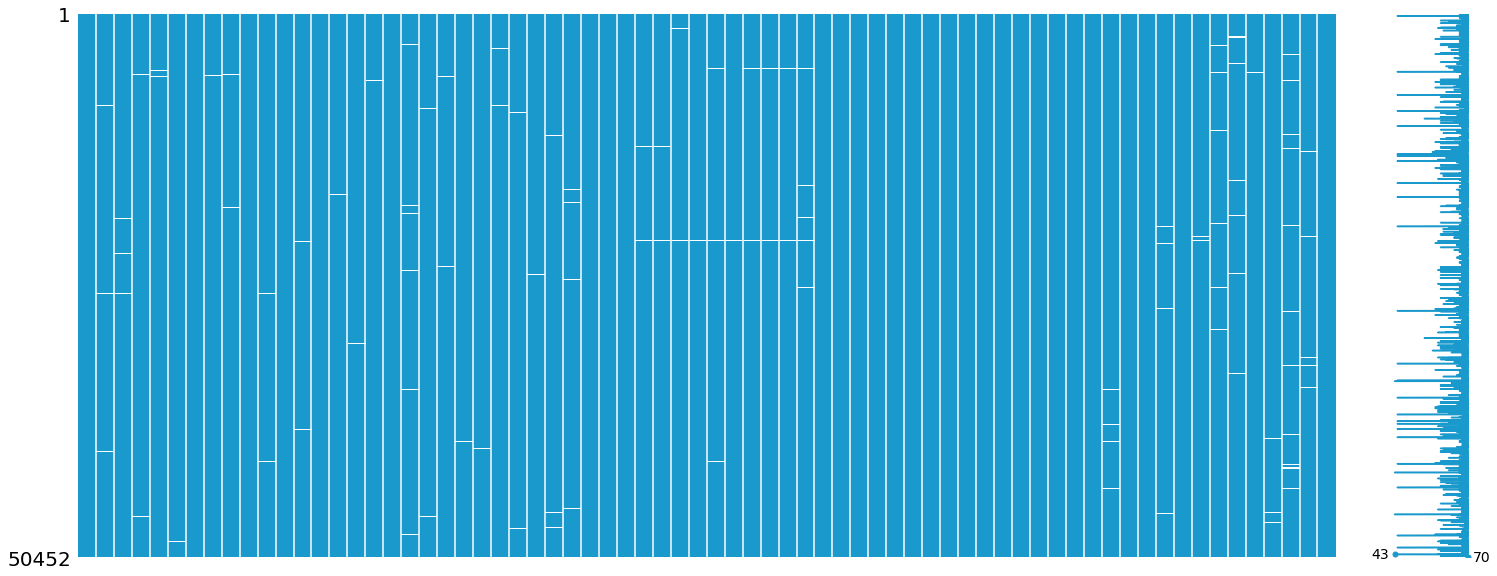

In [14]:
# missing value check
msno.matrix(data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 3. Preprocessing
data -> processed_data (**15,000 x 70 -> 15,000 x 50**)

Basic 
- **Drop unnecessary features** 
    - index, country(...)
- **Handling missing values (...)**
    - **fillna 0**
        - education, gender, hand, religion, orientation, voted, married, ASD
        - 무응답은 0으로 채우기 (urban은 이미 0부터 시작) 
    - **imputation : simple method**
        
Question (Q, TIPI, VCL)
- Q scoring 
- TIPI scoring to 'O', 'C', 'E', 'A', 'N' 
- VCL scoring (he words at **VCL6, VCL9, and VCL12** are not real words and can be used as a validity check)
    
Numerical
- **Log Transformation**
    - 3 elapse cols (intro, test, survey)
- **Ranging**
    - 'age' to 10 category (0~10/10~20..90~100)
- **Handling outlier**
    - 'familysize' to make np.Nan and Iterative imputator


In [17]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature drop 
# 'index', 'country'
processed_data = data.drop(['index', 'country'], axis=1).copy()

In [18]:
# Handling missing values with simple imputator
# 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer

fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
processed_data[fill_cols].describe()

,education,gender,engnat,hand,religion,orientation,voted,married,ASD
count,50452.000000,50452.000000,50452.000000,50452.000000,50452.000000,50452.000000,50452.000000,50452.000000,50452.000000
mean,2.305498,1.707847,1.341447,1.186978,4.116322,1.848020,1.635038,1.174856,1.937597
std,0.919095,0.556909,0.473419,0.485749,3.412609,1.212026,0.480154,0.458577,0.241105
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000
50%,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,3.000000,2.000000,2.000000,1.000000,6.000000,2.000000,2.000000,1.000000,2.000000
max,4.000000,3.000000,2.000000,3.000000,12.000000,5.000000,2.000000,3.000000,2.000000


In [261]:
# # Lable Encoding : 'country' 
# from sklearn.preprocessing import LabelEncoder

# # labeling the other countries as 1 
# df_country = pd.DataFrame(data['country'].value_counts())
# others = df_country[df_country['country']==1].index.values.tolist()
# processed_data['country'] = processed_data['country'].apply(lambda x : 1 if x in others else x)

# le_cnt = LabelEncoder()
# processed_data['country'] = le_cnt.fit_transform(list(processed_data['country']))   
# print(le_cnt.classes_)

# # save encoder
# dump(le_cnt, open('labelencoder.pkl', 'wb'))

['1' 'ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BEL' 'BGD' 'BGR' 'BHR'
 'BHS' 'BIH' 'BRA' 'BRN' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'COL' 'CRI' 'CUW'
 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FJI'
 'FRA' 'FRO' 'FSM' 'GBR' 'GEO' 'GHA' 'GRC' 'GUM' 'HKG' 'HND' 'HRV' 'HUN'
 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KEN' 'KOR'
 'KWT' 'LBN' 'LTU' 'LUX' 'LVA' 'MAR' 'MEX' 'MKD' 'MLT' 'MOZ' 'MYS' 'NAM'
 'NGA' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'POL' 'PRI'
 'PRT' 'PRY' 'QAT' 'ROU' 'RUS' 'SAU' 'SDN' 'SGP' 'SLV' 'SRB' 'SSD' 'SVK'
 'SVN' 'SWE' 'THA' 'TTO' 'TUN' 'TUR' 'TWN' 'UKR' 'URY' 'USA' 'VEN' 'VNM'
 'ZAF' 'ZMB' 'nan']


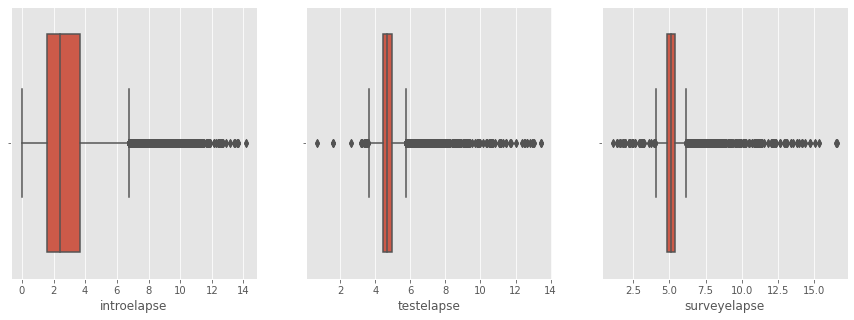

In [19]:
# Log Transformation
# 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# for checking 
plt.style.use("ggplot") 
plt.figure(figsize=(15,5))
    
for i in range(len(right_skewed_cols)):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=right_skewed_cols[i], data=processed_data)

In [20]:
# Ranging and Ordinary Encoding 
# 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)

oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data['age'].values.reshape(-1,1))
processed_data['age'].value_counts()

0.0    22926
1.0    17476
2.0     5012
3.0     2690
4.0     1532
5.0      664
6.0      110
9.0       24
7.0       12
8.0        6
Name: age, dtype: int64

count    50452.000000
mean         2.294955
std          0.836934
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


<AxesSubplot:xlabel='familysize'>

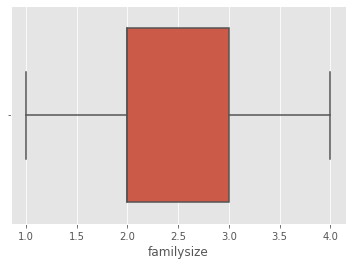

In [21]:
# Handling outlier
# 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize', 'nerdiness']] = transformer.fit_transform(processed_data[['familysize', 'nerdiness']])
print(processed_data['familysize'].describe())
sns.boxplot(x='familysize', data=processed_data)

<AxesSubplot:>

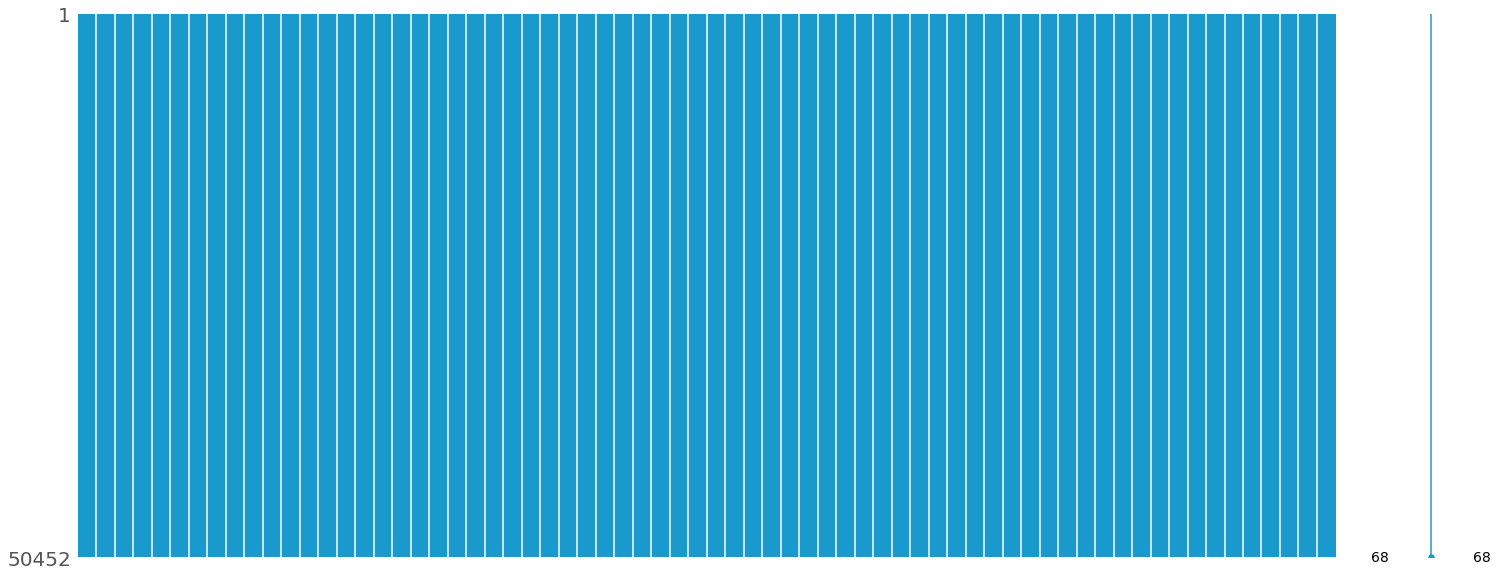

In [22]:
# finish handling missing values! 
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
nomach_cols = ['Q{}'.format(i) for i in range(21,27)]
q_cols = [npas_cols, tipi_cols, vcl_cols]

for col in q_cols : 
    transformer = SimpleImputer()
    processed_data[col] = transformer.fit_transform(processed_data[col])
    
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

the Nerdy Personality Attributes Scale

Your score was 30. Scores range from a low of 30 to a high of 70. The exact average score is 50. People who score higher on the NPAS are more likely to identify as nerds. Below is a graph of what percent of people say yes when asked the question "Are you a nerd?" based on what their NPAS score was.

http://openpsychometrics.org/tests/NPAS/development/

In [23]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

processed_data = score_mach(processed_data)
processed_data['Mach']

0        3.05
1        3.10
2        3.00
3        2.95
4        2.95
         ... 
35447    2.95
35448    2.80
35449    3.10
35450    2.60
35451    2.65
Name: Mach, Length: 50452, dtype: float64

TIPI scale scoring (“R” denotes reverse-scored items):



- Extraversion: 1, 6R; 

- Agreeableness: 2R, 7; 

- Conscientiousness; 3, 8R; 

- Emotional Stability: 4R, 9;

- Openness to Experiences: 5, 10R.

coring the TIPI

1. Recode the reverse-scored items (i.e., recode a 7 with a 1, a 6 with a 2, a 5 with a 3, etc.). The reverse scored items are 2, 4, 6, 8, & 10.

2. Take the AVERAGE of the two items (the standard item and the recoded reverse-scored item) that make up each scale.

Example using the Extraversion scale: A participant has scores of 5 on item 1 (Extraverted, enthusiastic) and and 2 on item 6 (Reserved, quiet). First, recode the reverse-scored item (i.e., item 6), replacing the 2 with a 6. Second, take the average of the score for item 1 and the (recoded) score for item 6. So the TIPI Extraversion scale score would be: (5 + 6)/2 = 5.5

https://gosling.psy.utexas.edu/scales-weve-developed/ten-item-personality-measure-tipi/

In [24]:
def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

processed_data = score_tipi(processed_data)
processed_data[['E', 'A', 'C', 'N', 'O']]

,E,A,C,N,O
0,3.5,5.0,5.0,6.0,4.0
1,5.0,5.5,5.0,2.5,4.5
2,2.0,4.5,3.5,6.0,5.5
3,4.0,4.5,3.5,3.5,5.0
4,3.5,4.0,4.0,3.5,5.0
...,...,...,...,...,...
35447,4.0,4.0,5.0,3.0,6.0
35448,3.0,5.0,5.0,2.0,4.5
35449,3.0,3.0,3.5,3.5,5.5
35450,3.0,4.0,6.0,6.0,6.0


VCL scale scoring

The following items were presented as a check-list and subjects were instructed "In the grid below, check all the words whose definitions you are sure you know":

A value of 1 is checked, 0 means unchecked. The words at VCL6, VCL9, and VCL12 are not real words and can be used as a validity check.

https://www.kaggle.com/datasets/lucasgreenwell/nerdy-personality-attributes-scale-responses

In [25]:
def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

processed_data = score_vcl(processed_data)
processed_data[['VCL_score', 'VCL_faker']]

,VCL_score,VCL_faker
0,8.0,0.0
1,11.0,0.0
2,11.0,0.0
3,9.0,0.0
4,8.0,0.0
...,...,...
35447,3.0,0.0
35448,9.0,0.0
35449,11.0,0.0
35450,10.0,3.0


<AxesSubplot:>

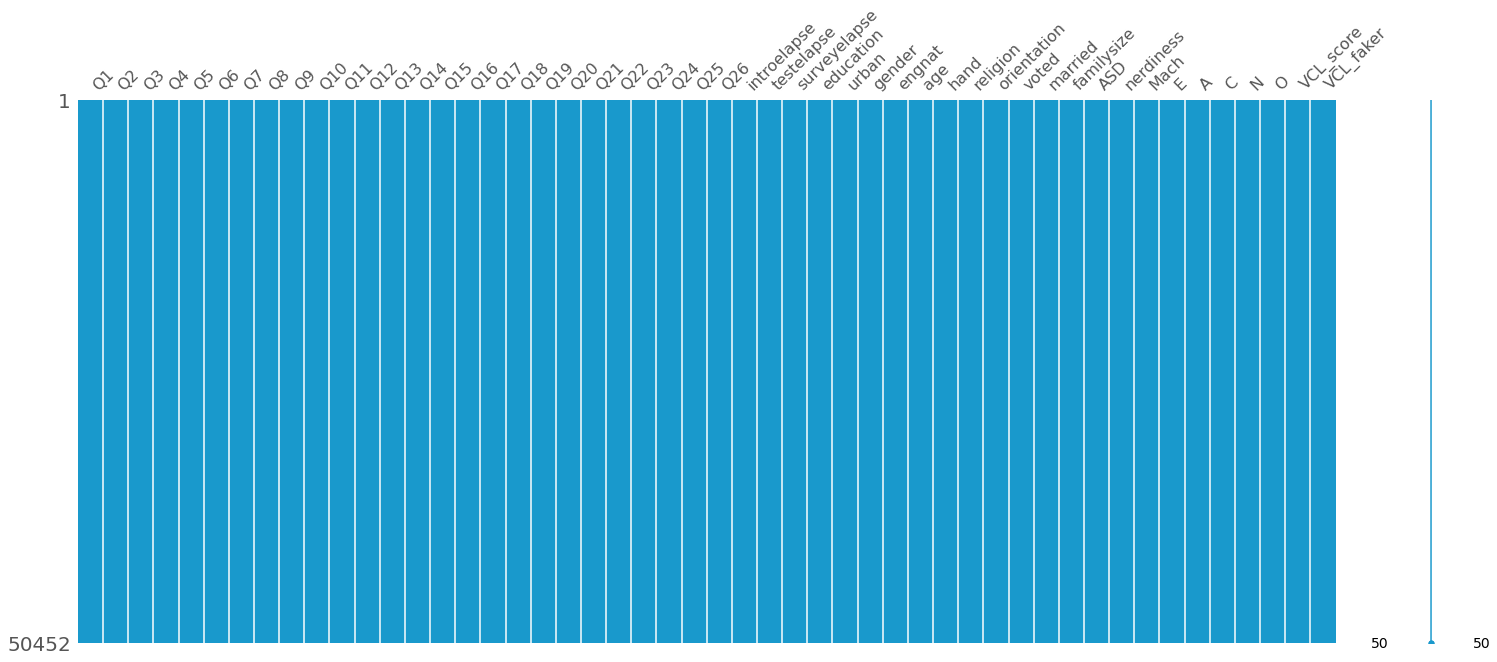

In [26]:
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 4. Data Split 
split data as train/valid

In [33]:
train_data = processed_data.iloc[:15000].copy()
test_data = processed_data.iloc[15000:].copy()

In [182]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data_y = input_data['nerdiness'].copy()
input_data_X = input_data.drop(['nerdiness'], axis=1)

# train/ test data 로 split 
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 7,
    shuffle=True
)

train_data = pd.concat([train_X, train_y], axis=1).reset_index(drop=True)
test_data = pd.concat([test_X, test_y], axis=1).reset_index(drop=True)

# 5. AutoML 

using pycaret, autoML Library

In [34]:
from pycaret.classification import *
from time import time

In [36]:
# Setup Environment  
cat_cols = ['urban', 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'] + npas_cols
num_cols = ['introelapse', 'testelapse', 'surveyelapse', 'familysize', 'Mach', 'E', 'A', 'C', 'N', 'O', 'VCL_score', 'VCL_faker'] 
ord_cols = ['age'] 
ord_dict = {} 
for col in ord_cols :
    unique_list = train_data[col].unique()
    unique_list = sorted(unique_list[~pd.isnull(unique_list)])
    ord_dict[col] = unique_list

clf = setup(data = train_data, 
            #train_size = 0.8,
            test_data = test_data,
            target = 'nerdiness',
            categorical_features = cat_cols,
            numeric_features = num_cols,
            ordinal_features = ord_dict,
            high_cardinality_features = ['religion'],
            high_cardinality_method = 'frequency',
            handle_unknown_categorical = True,
            data_split_stratify = True,
            normalize = True,
            normalize_method = 'zscore', 
            feature_selection = True, 
            fold_shuffle=True,
            use_gpu = True,
            silent = True,
            session_id = 6315)

,Description,Value
0,session_id,6315
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(15000, 50)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,36
8,Ordinal Features,True
9,High Cardinality Features,True


## Comparing

In [37]:
# et, rf, cat, lgbm, gbc
top5 = compare_models(sort='AUC', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7843,0.8728,0.8393,0.7857,0.8116,0.5601,0.5618,1.6260
rf,Random Forest Classifier,0.7831,0.8711,0.8357,0.7860,0.8101,0.5579,0.5593,1.2640
catboost,CatBoost Classifier,0.7796,0.8577,0.8366,0.7809,0.8078,0.5502,0.5521,5.6360
xgboost,Extreme Gradient Boosting,0.7874,0.8562,0.8307,0.7946,0.8122,0.5675,0.5683,1.0220
lightgbm,Light Gradient Boosting Machine,0.7682,0.8463,0.8277,0.7706,0.7981,0.5268,0.5288,0.1900
gbc,Gradient Boosting Classifier,0.7554,0.8300,0.8161,0.7598,0.7869,0.5007,0.5025,5.3100
ada,Ada Boost Classifier,0.7345,0.8114,0.7920,0.7447,0.7676,0.4588,0.4600,1.7120
lr,Logistic Regression,0.7264,0.7945,0.7873,0.7366,0.7611,0.4418,0.4432,1.2500
lda,Linear Discriminant Analysis,0.7258,0.7937,0.7888,0.7352,0.7610,0.4404,0.4419,0.3640
nb,Naive Bayes,0.6931,0.7519,0.7657,0.7053,0.7342,0.3727,0.3745,0.0980


## Training top 5 models

In [38]:
total_models = []

In [39]:
cell_start_time = time()
model_et = create_model('et', fold = 10)
total_models.append(model_et)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7867,0.8824,0.8412,0.7880,0.8137,0.5647,0.5664
1,0.7913,0.8812,0.8460,0.7917,0.8179,0.5742,0.5759
2,0.7787,0.8748,0.8400,0.7781,0.8079,0.5478,0.5500
3,0.7940,0.8893,0.8277,0.8054,0.8164,0.5819,0.5822
4,0.7947,0.8892,0.8410,0.7986,0.8192,0.5820,0.5830
5,0.7807,0.8717,0.8446,0.7780,0.8099,0.5517,0.5543
6,0.8113,0.8993,0.8687,0.8056,0.8359,0.6147,0.6171
7,0.7860,0.8809,0.8229,0.7970,0.8097,0.5654,0.5658
8,0.7747,0.8786,0.8084,0.7894,0.7988,0.5428,0.5430


CELL RUN TIME :  19.78027319908142


In [40]:
cell_start_time = time()
model_rf = create_model('rf', fold = 10)
total_models.append(model_rf)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7893,0.8784,0.8484,0.7877,0.8169,0.5697,0.5719
1,0.7927,0.8835,0.8508,0.7908,0.8197,0.5766,0.5787
2,0.7900,0.8699,0.8520,0.7867,0.8180,0.5707,0.5733
3,0.7953,0.8868,0.8265,0.8080,0.8172,0.5848,0.5850
4,0.8033,0.8935,0.8518,0.8043,0.8274,0.5993,0.6006
5,0.7867,0.8715,0.8554,0.7802,0.8161,0.5634,0.5668
6,0.8040,0.9005,0.8614,0.7998,0.8295,0.5998,0.6021
7,0.7813,0.8731,0.8277,0.7878,0.8073,0.5549,0.5558
8,0.7900,0.8777,0.8193,0.8047,0.8119,0.5742,0.5744


CELL RUN TIME :  14.591745138168335


In [41]:
cell_start_time = time()
model_cat = create_model('catboost', fold = 10)
total_models.append(model_cat)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7913,0.8610,0.8556,0.7865,0.8196,0.5732,0.5761
1,0.7893,0.8655,0.8556,0.7839,0.8182,0.5689,0.5720
2,0.7780,0.8563,0.8508,0.7718,0.8094,0.5451,0.5488
3,0.7693,0.8602,0.8169,0.7775,0.7967,0.5305,0.5314
4,0.7833,0.8665,0.8265,0.7912,0.8085,0.5593,0.5600
5,0.7720,0.8515,0.8373,0.7705,0.8025,0.5339,0.5365
6,0.8000,0.8800,0.8590,0.7958,0.8262,0.5915,0.5939
7,0.7900,0.8570,0.8373,0.7943,0.8152,0.5724,0.5735
8,0.7840,0.8623,0.8157,0.7983,0.8069,0.5619,0.5621


CELL RUN TIME :  66.77754640579224


In [42]:
cell_start_time = time()
model_lgbm = create_model('lightgbm', fold = 10)
total_models.append(model_lgbm)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7713,0.8516,0.8400,0.7687,0.8028,0.5320,0.5350
1,0.7780,0.8540,0.8460,0.7742,0.8085,0.5457,0.5487
2,0.7673,0.8390,0.8412,0.7631,0.8002,0.5233,0.5268
3,0.7673,0.8503,0.8072,0.7800,0.7934,0.5273,0.5277
4,0.7787,0.8586,0.8241,0.7862,0.8047,0.5496,0.5505
5,0.7680,0.8439,0.8386,0.7648,0.8000,0.5252,0.5284
6,0.7947,0.8704,0.8554,0.7906,0.8218,0.5805,0.5830
7,0.7727,0.8464,0.8229,0.7788,0.8002,0.5370,0.5381
8,0.7720,0.8504,0.8120,0.7837,0.7976,0.5368,0.5372


CELL RUN TIME :  2.44156551361084


In [43]:
cell_start_time = time()
model_xgb = create_model('xgboost', fold = 10)
total_models.append(model_xgb)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7953,0.8656,0.8448,0.7977,0.8206,0.5829,0.5842
1,0.7940,0.8631,0.8424,0.7973,0.8192,0.5803,0.5814
2,0.7853,0.8573,0.8387,0.7876,0.8124,0.5622,0.5637
3,0.7833,0.8689,0.8108,0.8002,0.8055,0.5610,0.5610
4,0.7813,0.8617,0.8205,0.7919,0.8059,0.5557,0.5562
5,0.7873,0.8567,0.8470,0.7855,0.8151,0.5657,0.5679
6,0.8007,0.8710,0.8410,0.8069,0.8236,0.5947,0.5954
7,0.7867,0.8593,0.8145,0.8029,0.8086,0.5677,0.5678
8,0.7880,0.8581,0.8120,0.8062,0.8091,0.5707,0.5708


CELL RUN TIME :  11.134299278259277


## Tuninig Models 

In [44]:
model_et = tune_model(model_et, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7233,0.7853,0.8242,0.7179,0.7674,0.4301,0.4363
1,0.7163,0.7833,0.8116,0.7147,0.7601,0.4166,0.4216
2,0.7187,0.7909,0.8170,0.7153,0.7628,0.4209,0.4265
3,0.7170,0.7944,0.8090,0.7163,0.7598,0.4185,0.4231
4,0.7120,0.7766,0.8042,0.7124,0.7555,0.4083,0.4127
Mean,0.7175,0.7861,0.8132,0.7153,0.7611,0.4189,0.4241
Std,0.0037,0.0062,0.0069,0.0018,0.0039,0.0070,0.0076


In [45]:
model_rf = tune_model(model_rf, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7247,0.7865,0.8248,0.7192,0.7684,0.4329,0.4391
1,0.7213,0.7862,0.8110,0.7207,0.7632,0.4276,0.4320
2,0.7250,0.7938,0.8194,0.7216,0.7674,0.4344,0.4396
3,0.7257,0.7973,0.8145,0.7242,0.7667,0.4366,0.4411
4,0.7133,0.7786,0.8048,0.7137,0.7565,0.4111,0.4155
Mean,0.7220,0.7885,0.8149,0.7199,0.7644,0.4285,0.4335
Std,0.0046,0.0065,0.0069,0.0035,0.0043,0.0092,0.0095


In [46]:
model_cat = tune_model(model_cat, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7970,0.8769,0.8537,0.7948,0.8232,0.5856,0.5876
1,0.7880,0.8724,0.8374,0.7917,0.8139,0.5681,0.5693
2,0.7930,0.8736,0.8399,0.7971,0.8179,0.5785,0.5795
3,0.7983,0.8898,0.8476,0.7999,0.8230,0.5891,0.5904
4,0.7853,0.8688,0.8325,0.7906,0.8110,0.5630,0.5640
Mean,0.7923,0.8763,0.8422,0.7948,0.8178,0.5768,0.5782
Std,0.0050,0.0072,0.0075,0.0034,0.0049,0.0100,0.0102


In [47]:
model_lgbm = tune_model(model_lgbm, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7637,0.8355,0.8110,0.7732,0.7917,0.5190,0.5198
1,0.7610,0.8316,0.8079,0.7713,0.7892,0.5136,0.5144
2,0.7707,0.8431,0.8092,0.7837,0.7962,0.5342,0.5345
3,0.7700,0.8481,0.8133,0.7803,0.7965,0.5324,0.5330
4,0.7567,0.8231,0.7946,0.7722,0.7833,0.5060,0.5063
Mean,0.7644,0.8363,0.8072,0.7762,0.7914,0.5210,0.5216
Std,0.0053,0.0088,0.0065,0.0049,0.0049,0.0108,0.0108


In [48]:
model_xgb = tune_model(model_xgb, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7133,0.8473,0.9693,0.6656,0.7892,0.3863,0.4593
1,0.7010,0.8338,0.9609,0.6573,0.7806,0.3595,0.4296
2,0.7223,0.8555,0.9699,0.6729,0.7946,0.4067,0.4769
3,0.7140,0.8578,0.9639,0.6672,0.7886,0.3890,0.4572
4,0.7157,0.8435,0.9584,0.6699,0.7886,0.3936,0.4570
Mean,0.7133,0.8476,0.9645,0.6666,0.7883,0.3870,0.4560
Std,0.0069,0.0086,0.0045,0.0053,0.0045,0.0155,0.0151


In [49]:
tuned_models = [model_et, model_rf, model_cat, model_lgbm, model_xgb]

## Blending Models

In [50]:
blender_top5 = blend_models(estimator_list=tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8167,0.8946,0.8700,0.8124,0.8402,0.6258,0.6278
1,0.8153,0.8989,0.8712,0.8098,0.8394,0.6228,0.6252
2,0.8073,0.8858,0.8700,0.7998,0.8334,0.6059,0.6090
3,0.8187,0.9024,0.8506,0.8267,0.8385,0.6319,0.6322
4,0.8160,0.8997,0.8566,0.8191,0.8375,0.6257,0.6266
5,0.8073,0.8866,0.8723,0.7982,0.8336,0.6059,0.6092
6,0.8253,0.9110,0.8819,0.8170,0.8482,0.6433,0.6459
7,0.8087,0.8899,0.8470,0.8146,0.8305,0.6111,0.6117
8,0.8107,0.8924,0.8325,0.8266,0.8295,0.6166,0.6167


## Plotting

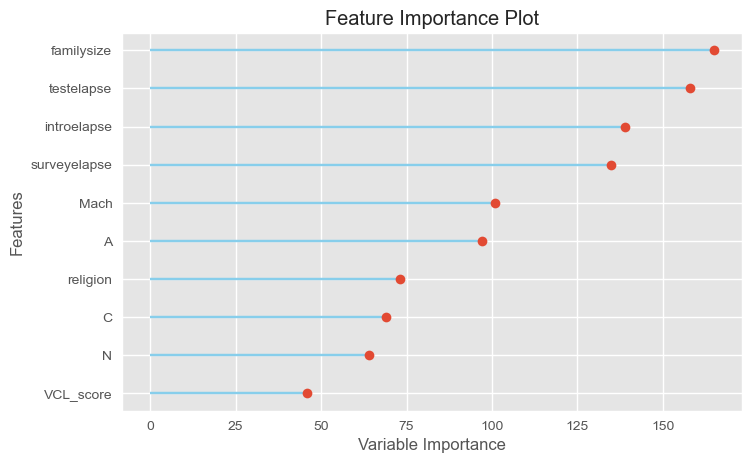

In [167]:
plot_model(model_lgbm, plot='feature')

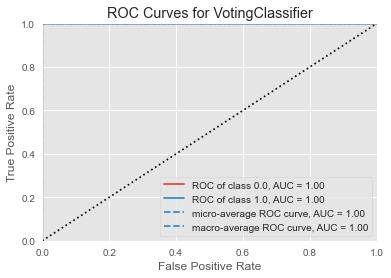

In [161]:
plot_model(blender_top5, plot='auc')

## Prediction for Test data 

In [199]:
# for total models 
for model in total_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7920,0.8824,0.8297,0.8047,0.8170,0.5762,0.5766


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7940,0.8830,0.8410,0.8009,0.8205,0.5792,0.5801


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7850,0.8705,0.8273,0.7964,0.8116,0.5615,0.5620


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7817,0.8636,0.8177,0.7973,0.8074,0.5555,0.5557


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7643,0.8435,0.8058,0.7803,0.7929,0.5197,0.5201


In [200]:
# for tuned models 
for model in tuned_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7920,0.8824,0.8297,0.8047,0.8170,0.5762,0.5766


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7940,0.8830,0.8410,0.8009,0.8205,0.5792,0.5801


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8037,0.8902,0.8356,0.8176,0.8265,0.6005,0.6007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7817,0.8636,0.8177,0.7973,0.8074,0.5555,0.5557


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7880,0.8651,0.8207,0.8044,0.8125,0.5687,0.5688


In [201]:
# for blended model 
prediction = predict_model(blender_top5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8150,0.9010,0.8440,0.8287,0.8362,0.6237,0.6239


# 6. Submission

In [51]:
pred = predict_model(blender_top5, raw_score=True)
pred[['Label', 'Score_1.0']].head(20)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.4416,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Label,Score_1.0
0,0.0,0.2402
1,0.0,0.4025
2,1.0,0.8972
3,1.0,0.5106
4,1.0,0.8461
5,0.0,0.0456
6,1.0,0.6569
7,1.0,0.8363
8,0.0,0.4044
9,0.0,0.1771


In [52]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv(path + 'sample_submission.csv')
submission.head()

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1


In [53]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['nerdiness'] = pred['Score_1.0']

# 데이터가 잘 들어갔는지 확인합니다.
submission

,index,nerdiness
0,0,0.2402
1,1,0.4025
2,2,0.8972
3,3,0.5106
4,4,0.8461
...,...,...
35447,35447,0.7806
35448,35448,0.7944
35449,35449,0.9568
35450,35450,0.0794


In [54]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M_%S")
filename

'0813_00_50_01'

In [55]:
submission.to_csv(path+"{}.csv".format(filename), index=False)

# 7. Saving Models

In [155]:
final_model = blender_top5 # you should fill out this 

In [40]:
# makes overfitting!! 
final_model = finalize_model(blender_top5) # you should fill out this 

In [156]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M")
filename = 'AUC90_alltrain_'+filename
filename

'AUC90_alltrain_0812_21_30'

In [157]:
save_model(final_model,path+filename)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['urban',
                                                             'education',
                                                             'gender', 'engnat',
                                                             'hand', 'religion',
                                                             'orientation',
                                                             'voted', 'married',
                                                             'ASD', 'Q1', 'Q2',
                                                             'Q3', 'Q4', 'Q5',
                                                             'Q6', 'Q7', 'Q8',
                                                             'Q9', 'Q10', 'Q11',
                                                             'Q12', 'Q13', 'Q14',
                                                             'Q15', 'Q16', 'Q17',
   